# Sign Language Image Classification with Vision Transformers

### Dataset Preprocessing  for Vision Transformer (ViT) Model

### **Load Dataset**
   - The dataset is loaded using Keras's `image_dataset_from_directory` function.
   - Images are resized to 224x224 to match the input size of the ViT model.

### **Model and Feature Extractor Loading**:
   - The Vision Transformer model `vit-tiny-patch16` is loaded from the `transformers` library.
   - The corresponding feature extractor is also loaded to preprocess images for the model.

### **Preprocessing**:
   - A `preprocess_vit` function applies the feature extractor transformations to normalize and prepare images for the ViT model.
   - The dataset is mapped to this preprocessing function with parallelization for improved performance.

### **Dataset Splitting**:
   - The dataset is split into training (70%), validation (10%), and testing (20%) subsets.


### Install packages

### Import packages

In [1]:
# Import necessary libraries
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from timm import create_model
from tqdm import tqdm
import numpy as np


In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset  # Directly store the dataset (no need for split)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access the subset's data directly
        data = self.dataset[idx]
        image = data['image']
        label = data['label']

        if self.transform:
            image = self.transform(image)

        return image, label


## Load dataset

In [2]:


import os

# Set up dataset path and name
kaggle_dataset = "aykhannazimzada/azsl-dataset"
dataset_dir = "./sign-language-dataset"  # Path to store the dataset

# Ensure the dataset directory exists
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    print("Downloading dataset from Kaggle...")

    # Download and unzip the dataset
    os.system(f"kaggle datasets download -d {kaggle_dataset} -p {dataset_dir} --unzip")
    print("Dataset downloaded and unzipped.")
else:
    print("Dataset already downloaded.")



Dataset downloaded and unzipped.


In [3]:
import os

def count_classes(dataset_dir):
    if not os.path.exists(dataset_dir):
        print(f"Dataset directory not found: {dataset_dir}")
        return 0

    class_folders = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    return len(class_folders)

# Define dataset paths
original_dataset_dir = "./sign-language-dataset/AzSL Dataset"
filtered_dataset_dir = "./sign-language-images-only/AzSL Dataset"

# Count number of classes (folders)
original_class_count = count_classes(original_dataset_dir)
filtered_class_count = count_classes(filtered_dataset_dir)

# Print results
print(f"Original Dataset (Before Filtering): {original_class_count} classes")
print(f"Filtered Dataset (After Removing Videos): {filtered_class_count} classes")


Dataset directory not found: ./sign-language-images-only/AzSL Dataset
Original Dataset (Before Filtering): 32 classes
Filtered Dataset (After Removing Videos): 0 classes


In [4]:
from datasets import load_dataset

# Specify the correct path for the dataset
dataset_path = "./sign-language-dataset/AzSL Dataset"
dataset = load_dataset('imagefolder', data_dir=dataset_path)

# Print dataset details to verify
print(dataset)


Resolving data files:   0%|          | 0/13492 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10948
    })
})


In [15]:
from PIL import Image

# Set the dataset path
dataset_path = "./sign-language-dataset/AzSL Dataset/A/A1.jpg"

# Load the image
img = Image.open(dataset_path)

# Print the image dimensions (width, height)
print(f'Image dimensions: {img.size}')



Image dimensions: (720, 1280)


In [21]:
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total_pixels = 0  # Total number of pixels across all images

    for images, _ in loader:
        # Number of pixels in the batch (batch_size x height x width)
        batch_pixels = images.size(0) * images.size(2) * images.size(3)
        total_pixels += batch_pixels

        # Sum of means for the batch (across channels)
        mean += images.sum(dim=[0, 2, 3])  # Sum over height and width
        # Sum of squared differences for the batch
        std += (images ** 2).sum(dim=[0, 2, 3])

    # Divide by the total number of pixels to get the mean
    mean /= total_pixels
    # Divide by the total number of pixels, then sqrt to get the std
    std = torch.sqrt(std / total_pixels - mean ** 2)
    return mean, std

In [22]:
def calculate_num_classes(dataset):
    labels = [example['label'] for example in dataset]
    num_classes = len(set(labels))  # Get unique labels
    return num_classes

In [23]:
transform_resized = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the image to 224x224
    transforms.ToTensor(),            # Convert image to tensor
])

In [24]:
# Ensure you're passing the correct split of the dataset to CustomDataset
train_split = dataset['train']  # Access the 'train' split of your dataset

# Create the transformed dataset
train_dataset_transformed = CustomDataset(train_split, transform=transform_resized)

# Calculate mean and std using the transformed dataset
mean, std = calculate_mean_std(train_dataset_transformed)

# Print the calculated mean and std
print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.5590, 0.4989, 0.4556])
Std: tensor([0.2270, 0.2216, 0.2243])


In [25]:
def calculate_num_classes(dataset):
    labels = [example['label'] for example in dataset]
    num_classes = len(set(labels))  # Get unique labels
    return num_classes

In [28]:
num_classes = calculate_num_classes(dataset['train'])
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 24


In [5]:
# mean, std = calculate_mean_std(dataset['train'])
num_classes = 24
mean = [0.5590, 0.4989, 0.4556]
std = [0.2270, 0.2216, 0.2243]
print(f"Number of classes: {num_classes}")
print(f" calculated mean: {mean}")
print(f" calculated std: {std}")

Number of classes: 24
 calculated mean: [0.559, 0.4989, 0.4556]
 calculated std: [0.227, 0.2216, 0.2243]


In [8]:
from torch.utils.data import random_split
# Define the transform for resizing images to 224x224, including normalization
transform_resized = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize the image to 224x224
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize(mean, std)  # Normalize the image with CIFAR-10 mean and std
])


total_size = len(dataset['train'])
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size


train_dataset, val_dataset, test_dataset = random_split(
    dataset['train'], [train_size, val_size, test_size]
)

# Wrap datasets with transform
train_dataset = CustomDataset(train_dataset, transform=transform_resized)
val_dataset = CustomDataset(val_dataset, transform=transform_resized)
test_dataset = CustomDataset(test_dataset, transform=transform_resized)

# Define DataLoaders for the training, validation, and test datasets
batch_size = 64
train_loader_resized = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_resized = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader_resized = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Model Training - Full Vit Training

#### Trainer Class

In [9]:
import torch
from tqdm import tqdm

class Trainer:
    def __init__(self, model, optimizer, loss_fn, device, scheduler=None, patience=5, min_delta=0.001):
        """
        Initialize the Trainer class with early stopping.

        Args:
            model (torch.nn.Module): The model to train.
            optimizer (torch.optim.Optimizer): Optimizer for updating weights.
            loss_fn (torch.nn.Module): Loss function.
            device (torch.device): Device to run training (CPU/GPU).
            scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Default is None.
            patience (int): Number of epochs with no improvement after which training will be stopped.
            min_delta (float): Minimum change in validation loss to qualify as an improvement.
        """
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.scheduler = scheduler  # Optional scheduler
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_epoch = 0

    def train_epoch(self, train_loader):
        """Train for one epoch and return loss and accuracy."""
        self.model.train()
        total_loss = 0
        correct = 0

        with tqdm(train_loader, desc="Training", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)
                loss.backward()
                self.optimizer.step()

                # Track loss and correct predictions
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

                t.set_postfix(loss=loss.item())
        
        # Compute average loss and accuracy
        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = correct / len(train_loader.dataset)
        return avg_loss, accuracy

    @torch.no_grad()
    def evaluate(self, dataloader):
        """Evaluate the model and return loss and accuracy."""
        self.model.eval()
        total_loss = 0
        correct = 0

        with tqdm(dataloader, desc="Validating", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)

                # Track loss and correct predictions
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

        # Compute average loss and accuracy
        avg_loss = total_loss / len(dataloader.dataset)
        accuracy = correct / len(dataloader.dataset)
        return avg_loss, accuracy

    def get_current_lr(self):
        """Retrieve the current learning rate from the optimizer."""
        return self.optimizer.param_groups[0]['lr']

    def train(self, train_loader, val_loader, epochs):
        """Train the model and evaluate it after each epoch, with early stopping."""
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
        learning_rates = []  # Track learning rate for each epoch

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            
            # Training phase
            train_loss, train_accuracy = self.train_epoch(train_loader)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            
            # Validation phase
            val_loss, val_accuracy = self.evaluate(val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            # Get the learning rate
            current_lr = self.get_current_lr()
            learning_rates.append(current_lr)
            
            # Print epoch metrics
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")
            
            # Step the scheduler, if provided
            if self.scheduler:
                self.scheduler.step(val_loss)  # Use validation loss for ReduceLROnPlateau
            
            # Early stopping condition
            if val_loss < self.best_val_loss - self.min_delta:
                self.best_val_loss = val_loss
                self.best_epoch = epoch
            elif epoch - self.best_epoch >= self.patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
            
            torch.cuda.empty_cache()

        return train_losses, train_accuracies, val_losses, val_accuracies, learning_rates


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


# ViT Tiny 

In [29]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model

# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)


# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=1e-4, weight_decay=5e-4
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(
    model, optimizer, loss_fn, device, scheduler=None, patience=1, min_delta=0.001
)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=6
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/6


Validating: 100%|██████████| 35/35 [00:39<00:00,  1.12s/batch]


Train Loss: 1.4483, Train Accuracy: 0.5621
Validation Loss: 0.5271, Validation Accuracy: 0.8328
Learning Rate: 0.000100
Epoch 2/6


Validating: 100%|██████████| 35/35 [00:39<00:00,  1.12s/batch]


Train Loss: 0.2964, Train Accuracy: 0.9092
Validation Loss: 0.3788, Validation Accuracy: 0.8826
Learning Rate: 0.000100
Epoch 3/6


Validating: 100%|██████████| 35/35 [00:39<00:00,  1.13s/batch]


Train Loss: 0.0993, Train Accuracy: 0.9748
Validation Loss: 0.3260, Validation Accuracy: 0.9018
Learning Rate: 0.000100
Epoch 4/6


Validating: 100%|██████████| 35/35 [00:39<00:00,  1.12s/batch]


Train Loss: 0.0351, Train Accuracy: 0.9930
Validation Loss: 0.3174, Validation Accuracy: 0.9118
Learning Rate: 0.000100
Epoch 5/6


Validating: 100%|██████████| 35/35 [00:39<00:00,  1.12s/batch]

Train Loss: 0.0128, Train Accuracy: 0.9984
Validation Loss: 0.3181, Validation Accuracy: 0.9100
Learning Rate: 0.000100
Early stopping at epoch 5
Learning rates per epoch: [0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
Training completed in: 981.95 seconds


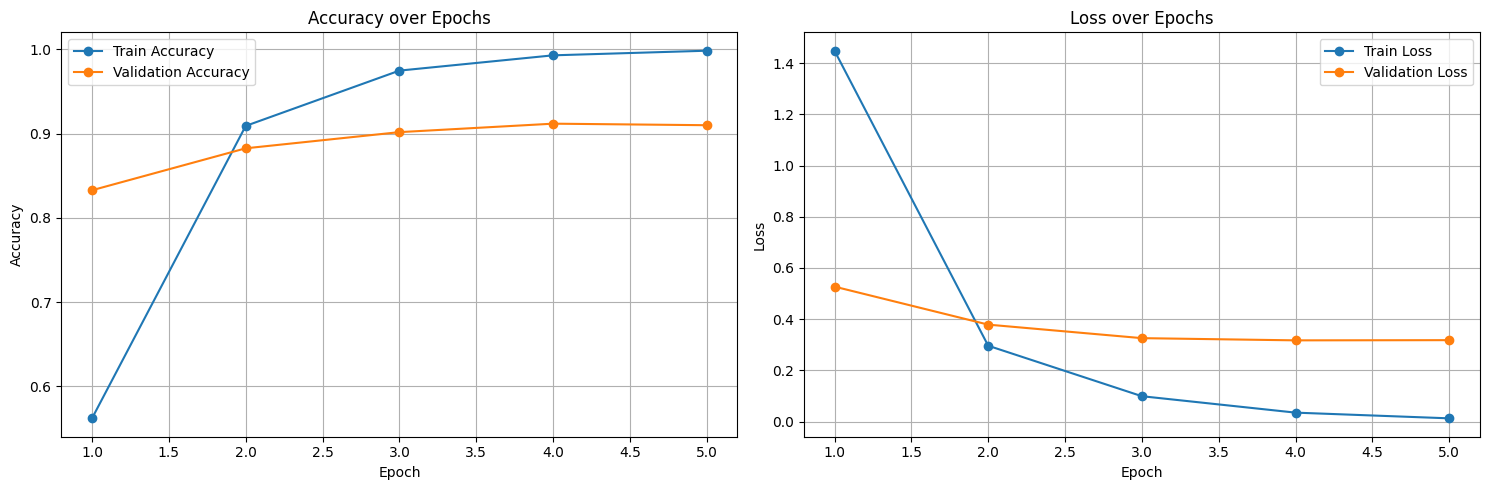

In [30]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [31]:
# Generate predictions and true labels for the classifier
y_true_classifier = []
y_pred_classifier = []
class_names = dataset['train'].features['label'].names

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Ensure val_loader_resized is defined
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())


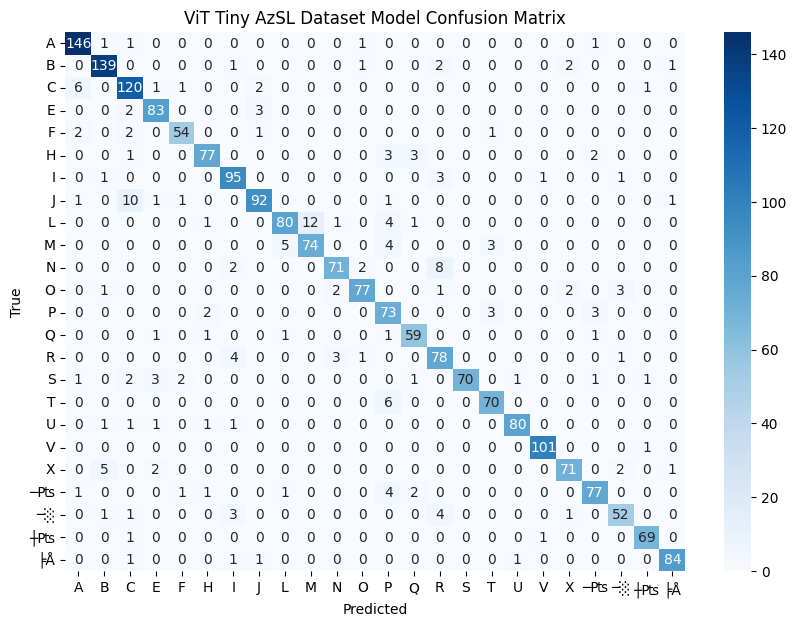

In [32]:
plot_confusion_matrix(y_true_classifier, y_pred_classifier, class_names, title="ViT Tiny AzSL Dataset Model Confusion Matrix")


In [33]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 18/18 [00:20<00:00,  1.15s/batch]

Test Loss: 0.2917, Test Accuracy: 0.9270


# ViT Tiny Classifier

In [16]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import time

# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

# Only unfreeze the classifier head
for param in model.head.parameters():
    param.requires_grad = True


# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=1e-3, weight_decay=1e-3
)
# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train only the classifier head
trainer = Trainer(
    model, optimizer, loss_fn, device, scheduler=None, patience=15, min_delta=0.001
)
start_time = time.time()
train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=20
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/20


Validating: 100%|██████████| 35/35 [00:45<00:00,  1.31s/batch]


Train Loss: 2.7829, Train Accuracy: 0.1797
Validation Loss: 2.3743, Validation Accuracy: 0.2915
Learning Rate: 0.001000
Epoch 2/20


Validating: 100%|██████████| 35/35 [00:44<00:00,  1.27s/batch]


Train Loss: 2.1920, Train Accuracy: 0.3338
Validation Loss: 2.1498, Validation Accuracy: 0.3568
Learning Rate: 0.001000
Epoch 3/20


Validating: 100%|██████████| 35/35 [00:44<00:00,  1.28s/batch]


Train Loss: 1.9974, Train Accuracy: 0.3861
Validation Loss: 2.0399, Validation Accuracy: 0.3865
Learning Rate: 0.001000
Epoch 4/20


Validating: 100%|██████████| 35/35 [00:45<00:00,  1.30s/batch]


Train Loss: 1.8961, Train Accuracy: 0.4182
Validation Loss: 2.0421, Validation Accuracy: 0.3783
Learning Rate: 0.001000
Epoch 5/20


Validating: 100%|██████████| 35/35 [00:45<00:00,  1.29s/batch]


Train Loss: 1.8247, Train Accuracy: 0.4372
Validation Loss: 1.9705, Validation Accuracy: 0.3942
Learning Rate: 0.001000
Epoch 6/20


Validating: 100%|██████████| 35/35 [00:45<00:00,  1.29s/batch]


Train Loss: 1.7744, Train Accuracy: 0.4458
Validation Loss: 1.9664, Validation Accuracy: 0.3993
Learning Rate: 0.001000
Epoch 7/20


Validating: 100%|██████████| 35/35 [00:43<00:00,  1.25s/batch]


Train Loss: 1.7344, Train Accuracy: 0.4664
Validation Loss: 1.9590, Validation Accuracy: 0.3956
Learning Rate: 0.001000
Epoch 8/20


Validating: 100%|██████████| 35/35 [00:44<00:00,  1.27s/batch]


Train Loss: 1.7093, Train Accuracy: 0.4644
Validation Loss: 1.9460, Validation Accuracy: 0.4116
Learning Rate: 0.001000
Epoch 9/20


Validating: 100%|██████████| 35/35 [00:44<00:00,  1.26s/batch]


Train Loss: 1.6848, Train Accuracy: 0.4771
Validation Loss: 1.9474, Validation Accuracy: 0.4089
Learning Rate: 0.001000
Epoch 10/20


Validating: 100%|██████████| 35/35 [00:43<00:00,  1.24s/batch]


Train Loss: 1.6681, Train Accuracy: 0.4801
Validation Loss: 1.9685, Validation Accuracy: 0.4006
Learning Rate: 0.001000
Epoch 11/20


Validating: 100%|██████████| 35/35 [00:42<00:00,  1.22s/batch]


Train Loss: 1.6518, Train Accuracy: 0.4913
Validation Loss: 1.9524, Validation Accuracy: 0.4075
Learning Rate: 0.001000
Epoch 12/20


Validating: 100%|██████████| 35/35 [00:42<00:00,  1.22s/batch]


Train Loss: 1.6382, Train Accuracy: 0.4890
Validation Loss: 1.9554, Validation Accuracy: 0.4089
Learning Rate: 0.001000
Epoch 13/20


Validating: 100%|██████████| 35/35 [00:42<00:00,  1.20s/batch]


Train Loss: 1.6278, Train Accuracy: 0.4896
Validation Loss: 1.9814, Validation Accuracy: 0.4070
Learning Rate: 0.001000
Epoch 14/20


Validating: 100%|██████████| 35/35 [00:42<00:00,  1.21s/batch]


Train Loss: 1.6200, Train Accuracy: 0.4920
Validation Loss: 1.9667, Validation Accuracy: 0.4038
Learning Rate: 0.001000
Epoch 15/20


Validating: 100%|██████████| 35/35 [00:41<00:00,  1.19s/batch]


Train Loss: 1.6040, Train Accuracy: 0.5012
Validation Loss: 1.9565, Validation Accuracy: 0.4171
Learning Rate: 0.001000
Epoch 16/20


Validating: 100%|██████████| 35/35 [00:42<00:00,  1.21s/batch]


Train Loss: 1.6029, Train Accuracy: 0.5032
Validation Loss: 1.9649, Validation Accuracy: 0.4143
Learning Rate: 0.001000
Epoch 17/20


Validating: 100%|██████████| 35/35 [00:41<00:00,  1.19s/batch]


Train Loss: 1.5948, Train Accuracy: 0.5055
Validation Loss: 1.9386, Validation Accuracy: 0.4194
Learning Rate: 0.001000
Epoch 18/20


Validating: 100%|██████████| 35/35 [00:41<00:00,  1.19s/batch]


Train Loss: 1.5939, Train Accuracy: 0.5038
Validation Loss: 1.9597, Validation Accuracy: 0.4153
Learning Rate: 0.001000
Epoch 19/20


Validating: 100%|██████████| 35/35 [00:41<00:00,  1.19s/batch]


Train Loss: 1.5808, Train Accuracy: 0.5072
Validation Loss: 1.9606, Validation Accuracy: 0.4180
Learning Rate: 0.001000
Epoch 20/20


Validating: 100%|██████████| 35/35 [00:42<00:00,  1.20s/batch]

Train Loss: 1.5701, Train Accuracy: 0.5089
Validation Loss: 1.9594, Validation Accuracy: 0.4189
Learning Rate: 0.001000
Learning rates per epoch: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
Training completed in: 3854.93 seconds


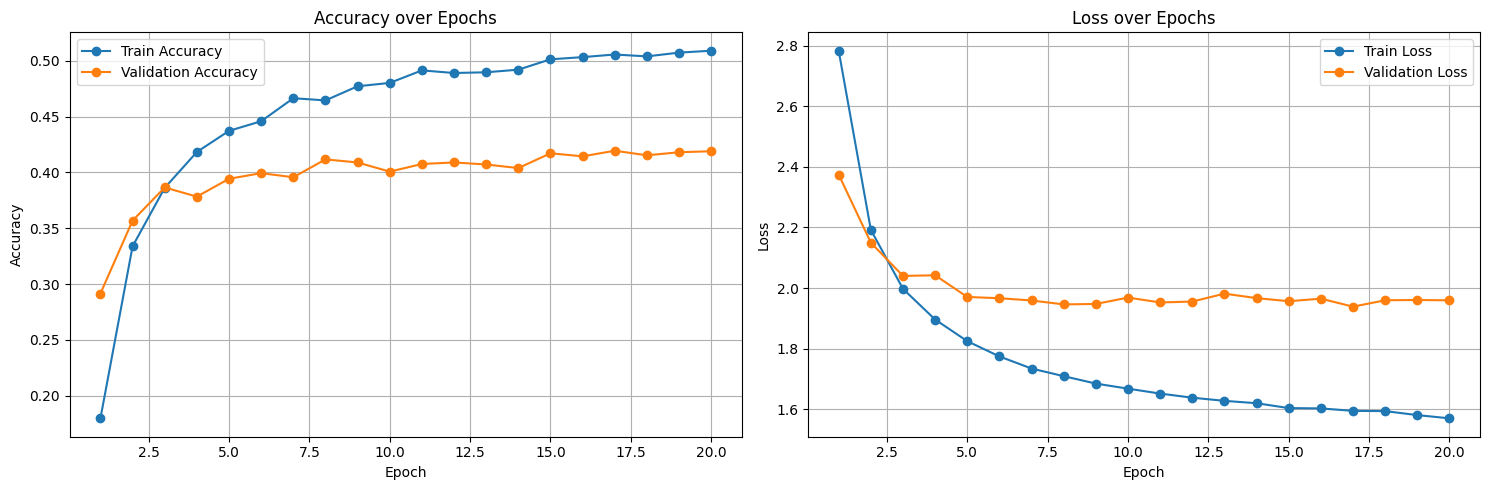

In [17]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [18]:
# Generate predictions and true labels for the classifier
y_true_classifier = []
y_pred_classifier = []
class_names = dataset['train'].features['label'].names

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Ensure val_loader_resized is defined
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

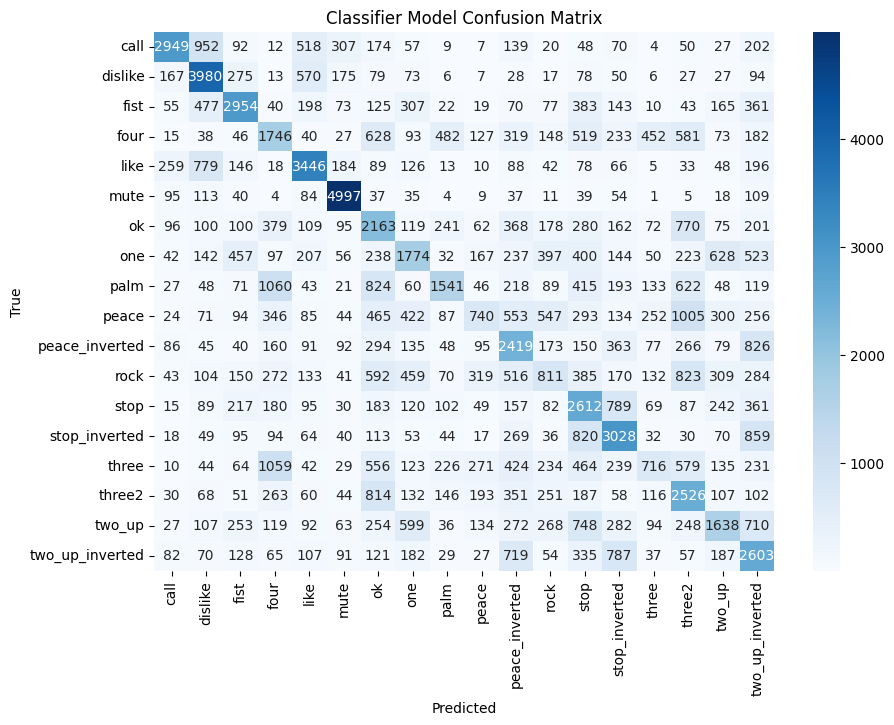

In [16]:
plot_confusion_matrix(y_true_classifier, y_pred_classifier, class_names, title="ViT Tiny Classifier azSL Model Confusion Matrix")


In [19]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)


Validating: 100%|██████████| 18/18 [00:20<00:00,  1.15s/batch]


In [18]:
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.8162, Test Accuracy: 0.4199


# ViT Base

In [47]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_base_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

# Only unfreeze the classifier head
for param in model.head.parameters():
    param.requires_grad = True


# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-3, weight_decay=1e-3
)
# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train only the classifier head
trainer = Trainer(
    model, optimizer, loss_fn, device, scheduler=None, patience=5, min_delta=0.001
)
start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=20 
)
# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/20


Validating: 100%|██████████| 35/35 [01:02<00:00,  1.78s/batch]


Train Loss: 2.0115, Train Accuracy: 0.3735
Validation Loss: 1.4672, Validation Accuracy: 0.5176
Learning Rate: 0.002000
Epoch 2/20


Validating: 100%|██████████| 35/35 [01:02<00:00,  1.78s/batch]


Train Loss: 1.2262, Train Accuracy: 0.6009
Validation Loss: 1.3224, Validation Accuracy: 0.5601
Learning Rate: 0.002000
Epoch 3/20


Validating: 100%|██████████| 35/35 [01:02<00:00,  1.78s/batch]


Train Loss: 0.9821, Train Accuracy: 0.6923
Validation Loss: 1.2718, Validation Accuracy: 0.5811
Learning Rate: 0.002000
Epoch 4/20


Validating: 100%|██████████| 35/35 [01:02<00:00,  1.78s/batch]


Train Loss: 0.8428, Train Accuracy: 0.7329
Validation Loss: 1.2056, Validation Accuracy: 0.6039
Learning Rate: 0.002000
Epoch 5/20


Validating: 100%|██████████| 35/35 [01:02<00:00,  1.79s/batch]


Train Loss: 0.7547, Train Accuracy: 0.7624
Validation Loss: 1.2696, Validation Accuracy: 0.5957
Learning Rate: 0.002000
Epoch 6/20


Validating: 100%|██████████| 35/35 [01:02<00:00,  1.77s/batch]


Train Loss: 0.6664, Train Accuracy: 0.7911
Validation Loss: 1.1586, Validation Accuracy: 0.6277
Learning Rate: 0.002000
Epoch 7/20


Validating: 100%|██████████| 35/35 [01:02<00:00,  1.78s/batch]


Train Loss: 0.5826, Train Accuracy: 0.8228
Validation Loss: 1.1824, Validation Accuracy: 0.6309
Learning Rate: 0.002000
Epoch 8/20


Validating: 100%|██████████| 35/35 [01:02<00:00,  1.78s/batch]


Train Loss: 0.5436, Train Accuracy: 0.8387
Validation Loss: 1.1831, Validation Accuracy: 0.6291
Learning Rate: 0.002000
Epoch 9/20


Validating: 100%|██████████| 35/35 [01:02<00:00,  1.78s/batch]


Train Loss: 0.4994, Train Accuracy: 0.8562
Validation Loss: 1.2020, Validation Accuracy: 0.6286
Learning Rate: 0.002000
Epoch 10/20


Validating: 100%|██████████| 35/35 [01:02<00:00,  1.78s/batch]


Train Loss: 0.4694, Train Accuracy: 0.8593
Validation Loss: 1.2162, Validation Accuracy: 0.6300
Learning Rate: 0.002000
Epoch 11/20


Validating: 100%|██████████| 35/35 [01:02<00:00,  1.78s/batch]

Train Loss: 0.4334, Train Accuracy: 0.8775
Validation Loss: 1.2214, Validation Accuracy: 0.6313
Learning Rate: 0.002000
Early stopping at epoch 11
Learning rates per epoch: [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002]
Training completed in: 3095.97 seconds


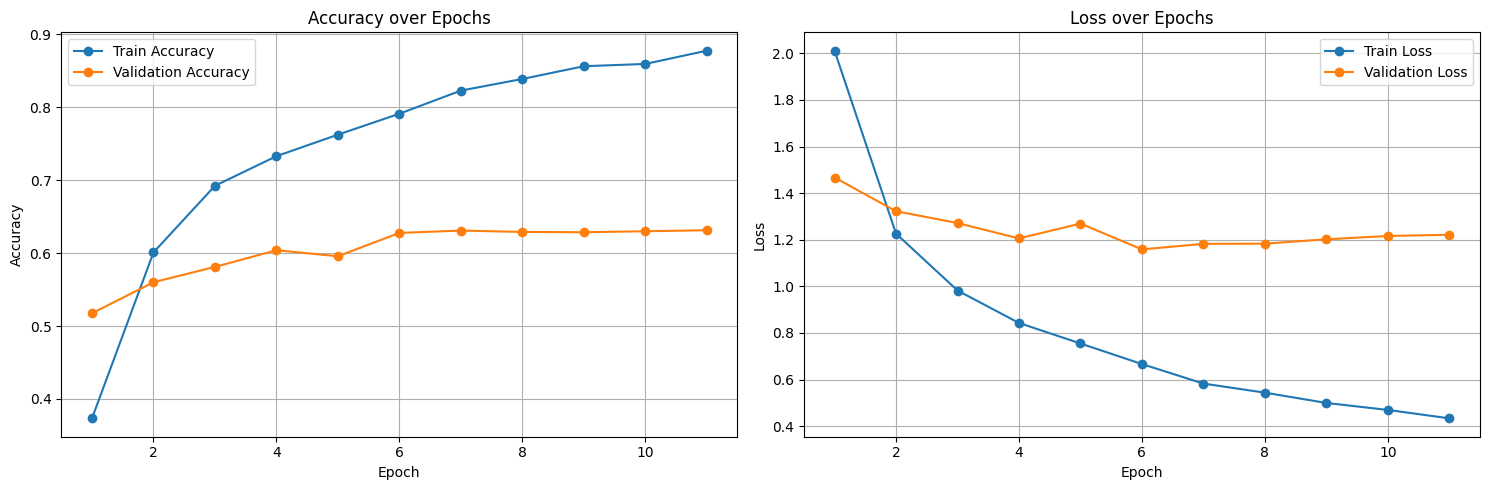

In [48]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [49]:
# Generate predictions and true labels for the classifier
y_true_classifier = []
y_pred_classifier = []
class_names = dataset['train'].features['label'].names

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Ensure val_loader_resized is defined
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

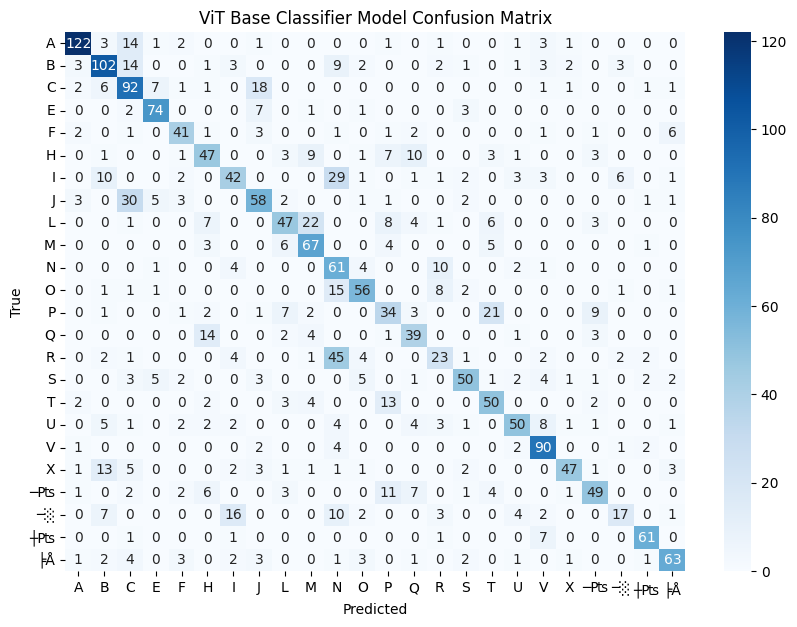

In [50]:
plot_confusion_matrix(y_true_classifier, y_pred_classifier, class_names, title="ViT Base Classifier Model Confusion Matrix")


In [51]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 18/18 [00:31<00:00,  1.75s/batch]

Test Loss: 1.3623, Test Accuracy: 0.5903


# EfficientViT

In [21]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "efficientvit_m5.r224_in1k",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)



# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=1e-4, weight_decay=5e-4
)


# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(
    model, optimizer, loss_fn, device, scheduler=None, patience=4, min_delta=0.001
)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=10
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/10


Validating: 100%|██████████| 35/35 [00:40<00:00,  1.17s/batch]


Train Loss: 3.0677, Train Accuracy: 0.1526
Validation Loss: 3.2167, Validation Accuracy: 0.3138
Learning Rate: 0.000100
Epoch 2/10


Validating: 100%|██████████| 35/35 [00:40<00:00,  1.17s/batch]


Train Loss: 2.4299, Train Accuracy: 0.4586
Validation Loss: 2.1402, Validation Accuracy: 0.5308
Learning Rate: 0.000100
Epoch 3/10


Validating: 100%|██████████| 35/35 [00:41<00:00,  1.17s/batch]


Train Loss: 1.6398, Train Accuracy: 0.6358
Validation Loss: 1.3116, Validation Accuracy: 0.7008
Learning Rate: 0.000100
Epoch 4/10


Validating: 100%|██████████| 35/35 [00:39<00:00,  1.14s/batch]


Train Loss: 1.0560, Train Accuracy: 0.7575
Validation Loss: 0.8933, Validation Accuracy: 0.7839
Learning Rate: 0.000100
Epoch 5/10


Validating: 100%|██████████| 35/35 [00:40<00:00,  1.17s/batch]


Train Loss: 0.6934, Train Accuracy: 0.8465
Validation Loss: 0.6788, Validation Accuracy: 0.8191
Learning Rate: 0.000100
Epoch 6/10


Validating: 100%|██████████| 35/35 [00:40<00:00,  1.15s/batch]


Train Loss: 0.4596, Train Accuracy: 0.9064
Validation Loss: 0.5747, Validation Accuracy: 0.8547
Learning Rate: 0.000100
Epoch 7/10


Validating: 100%|██████████| 35/35 [00:40<00:00,  1.15s/batch]


Train Loss: 0.3053, Train Accuracy: 0.9409
Validation Loss: 0.4928, Validation Accuracy: 0.8639
Learning Rate: 0.000100
Epoch 8/10


Validating: 100%|██████████| 35/35 [00:40<00:00,  1.17s/batch]


Train Loss: 0.2016, Train Accuracy: 0.9629
Validation Loss: 0.4570, Validation Accuracy: 0.8652
Learning Rate: 0.000100
Epoch 9/10


Validating: 100%|██████████| 35/35 [00:39<00:00,  1.14s/batch]


Train Loss: 0.1370, Train Accuracy: 0.9800
Validation Loss: 0.4491, Validation Accuracy: 0.8730
Learning Rate: 0.000100
Epoch 10/10


Validating: 100%|██████████| 35/35 [00:39<00:00,  1.14s/batch]

Train Loss: 0.0938, Train Accuracy: 0.9876
Validation Loss: 0.4586, Validation Accuracy: 0.8675
Learning Rate: 0.000100
Learning rates per epoch: [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
Training completed in: 1909.95 seconds


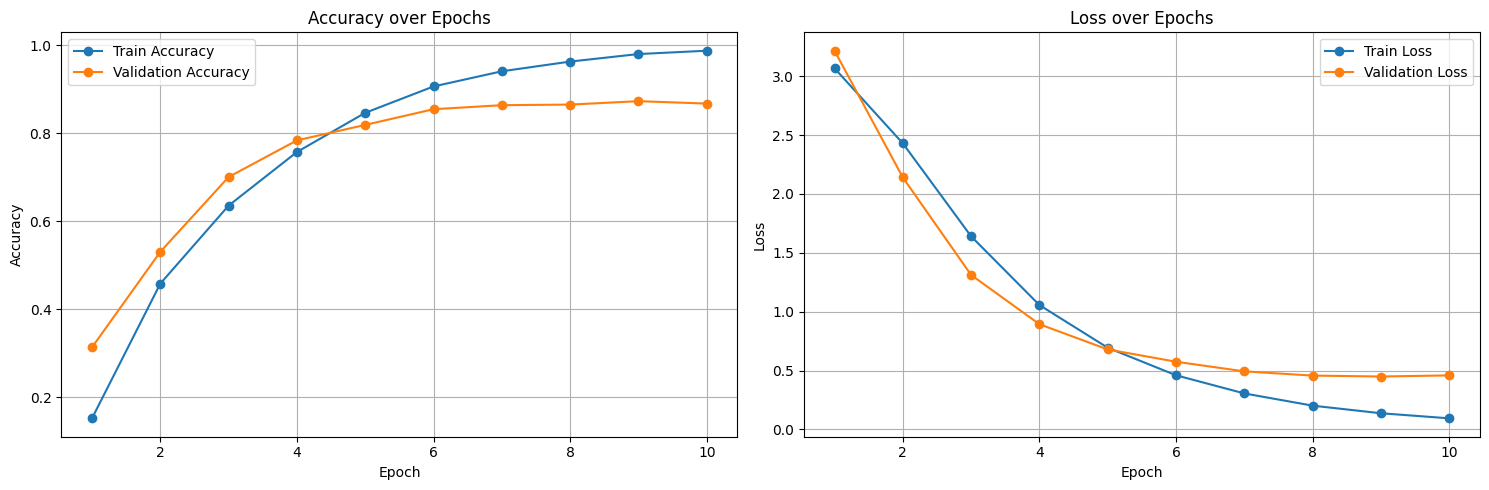

In [22]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [23]:
# Generate predictions and true labels for the classifier
y_true_classifier = []
y_pred_classifier = []
class_names = dataset['train'].features['label'].names

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Ensure val_loader_resized is defined
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

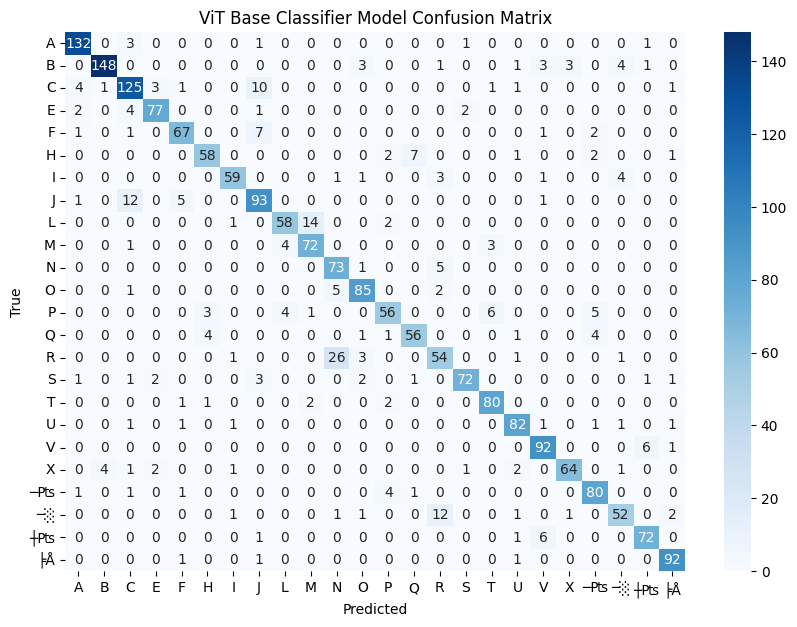

In [24]:
plot_confusion_matrix(y_true_classifier, y_pred_classifier, class_names, title="ViT Base Classifier Model Confusion Matrix")


In [25]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 18/18 [00:20<00:00,  1.12s/batch]

Test Loss: 0.4499, Test Accuracy: 0.8704


# DeIt III

In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "deit3_small_patch16_224.fb_in22k_ft_in1k",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)


# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=1e-4, weight_decay=1e-3
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=2
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

model.safetensors:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

Epoch 1/2


Validating: 100%|██████████| 35/35 [00:47<00:00,  1.37s/batch]


Train Loss: 1.0244, Train Accuracy: 0.6803
Validation Loss: 0.3150, Validation Accuracy: 0.8990
Learning Rate: 0.000100
Epoch 2/2


Validating: 100%|██████████| 35/35 [00:48<00:00,  1.39s/batch]

Train Loss: 0.1762, Train Accuracy: 0.9439
Validation Loss: 0.2617, Validation Accuracy: 0.9306
Learning Rate: 0.000100
Learning rates per epoch: [0.0001, 0.0001]
Training completed in: 553.93 seconds


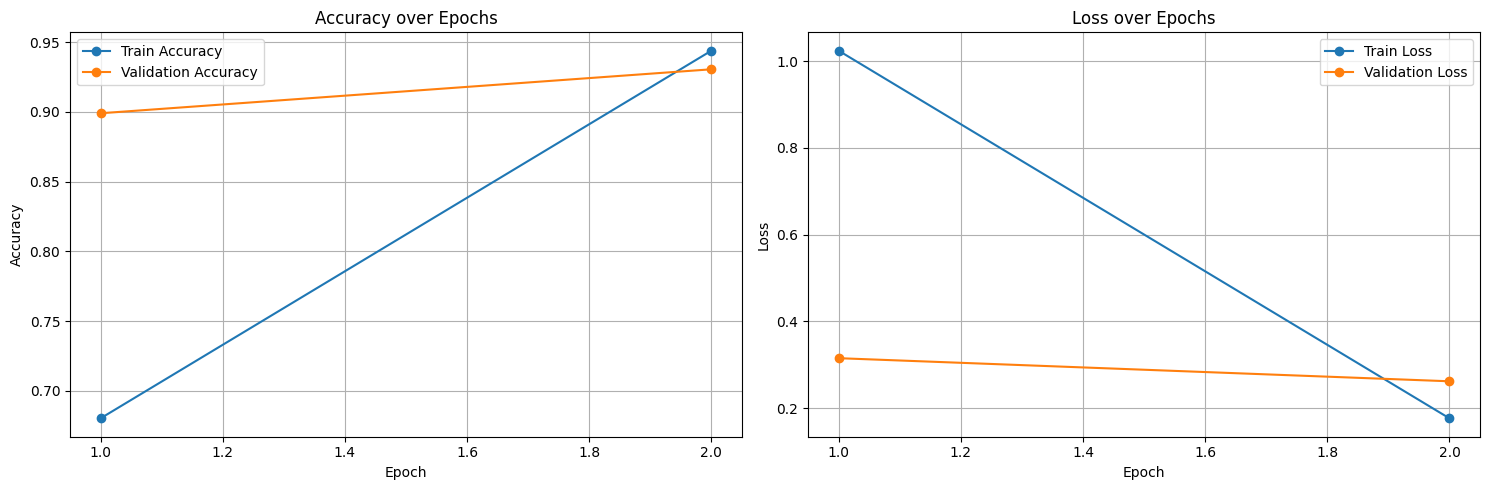

In [11]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [13]:
# Generate predictions and true labels for the classifier
y_true_classifier = []
y_pred_classifier = []
class_names = dataset['train'].features['label'].names

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Ensure val_loader_resized is defined
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

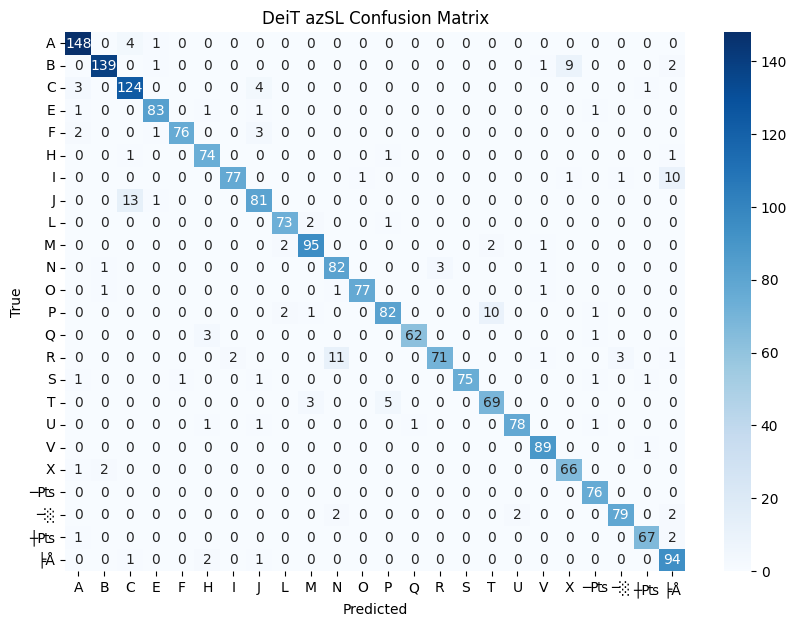

In [17]:


plot_confusion_matrix(y_true_classifier, y_pred_classifier, class_names, title="DeiT azSL Confusion Matrix")


In [18]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 18/18 [00:23<00:00,  1.33s/batch]

Test Loss: 0.2644, Test Accuracy: 0.9197
